Install required packages

In [1]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 8.0 MB/s eta 0:00:00


Request metadata

In [5]:
import requests

metadataURL = 'https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv';
response = requests.get(metadataURL);
metadataData = response.content;

Download metadata file

In [6]:
with open('metadata.csv', 'wb') as f:
  f.write(metadataData);

Get csv data from metadata

In [7]:
import csv

metadata = [];

with open('metadata.csv', 'r') as f:
  reader = csv.DictReader(f);

  for patient in reader:
    metadata.append(patient);

print(metadata[0]);

{'patientid': '2', 'offset': '0', 'sex': 'M', 'age': '65', 'finding': 'Pneumonia/Viral/COVID-19', 'RT_PCR_positive': 'Y', 'survival': 'Y', 'intubated': 'N', 'intubation_present': 'N', 'went_icu': 'N', 'in_icu': 'N', 'needed_supplemental_O2': 'Y', 'extubated': '', 'temperature': '', 'pO2_saturation': '', 'leukocyte_count': '', 'neutrophil_count': '', 'lymphocyte_count': '', 'view': 'PA', 'modality': 'X-ray', 'date': 'January 22, 2020', 'location': 'Cho Ray Hospital, Ho Chi Minh City, Vietnam', 'folder': 'images', 'filename': 'auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', 'doi': '10.1056/nejmc2001272', 'url': 'https://www.nejm.org/doi/full/10.1056/NEJMc2001272', 'license': '', 'clinical_notes': 'On January 22, 2020, a 65-year-old man with a history of hypertension, type 2 diabetes, coronary heart disease for which a stent had been implanted, and lung cancer was admitted to the emergency department of Cho Ray Hospital, the referral hospital in Ho Chi Minh City, 

Download covid images

In [ ]:
import os

baseImageURL = 'https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/images/';

if (os.path.isdir('images')):
  shutil.rmtree('images');

os.mkdir('images');
os.mkdir('images/has_covid');

n = len(metadata);

for i, patient in enumerate(metadata):
  hasCovid = patient['finding'] == 'Pneumonia/Viral/COVID-19';
  filename = patient['filename'];

  if ('gz' in filename or not hasCovid):
    continue;

  imageURL = baseImageURL + filename;
  response = requests.get(imageURL);

  filePath = f'images/has_covid/{filename}';

  with open(filePath, 'wb') as f:
      f.write(response.content);

  index = i + 1;
  print(f'Wrote image: {filePath} {index}:{n}');

Download normal images

In [ ]:
from google.colab import files
import os
import shutil

if (not os.path.exists('kaggle.json')):
  files.upload();

!ls -lha kaggle.json
!pip install -q kaggle # instlling the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

!chmod 600 ~/.kaggle/kaggle.json

if (not os.path.exists('/content/drive/MyDrive/chest-xray-pneumonia')):
  !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/drive/MyDrive/chest-xray-pneumonia

  !unzip /content/drive/MyDrive/chest-xray-pneumonia/chest-xray-pneumonia.zip -d /content/drive/MyDrive/chest-xray-pneumonia/chest-xray-pneumonia

if (not os.path.isdir('images/normal')):
  os.mkdir('images/normal');

files = os.listdir('/content/drive/MyDrive/chest-xray-pneumonia/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL');

for file in files:
    shutil.move('/content/drive/MyDrive/chest-xray-pneumonia/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/' + file, 'images/normal');

Get the dataset from the metadata

In [10]:
import tensorflow as tf
from tensorflow import keras

IMG_W = 224;
IMG_H = 224;
VALIDATION_SPLIT = 0.2;
BATCH_SIZE = 10;

trainingData = keras.utils.image_dataset_from_directory(
    "images",
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=123,
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
);

validationData = keras.utils.image_dataset_from_directory(
    "images",
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=123,
    image_size=(IMG_W, IMG_H),
    batch_size=BATCH_SIZE,
);

classNames = trainingData.class_names;

print(classNames);

Found 1904 files belonging to 2 classes.
Using 1524 files for training.
Found 1904 files belonging to 2 classes.
Using 380 files for validation.
['has_covid', 'normal']


Autotune dataset

In [11]:
AUTOTUNE = tf.data.AUTOTUNE;

trainingData = trainingData.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE);
validationData = validationData.cache().prefetch(buffer_size=AUTOTUNE);

Normalize and augment data

In [12]:
from tensorflow.keras import layers

normalizationLayer = layers.Rescaling(1.0 / 255);
normalizedData = trainingData.map(lambda x, y: (normalizationLayer(x), y));

imageBatch, labelsBatch = next(iter(normalizedData));

dataAugmentation = keras.Sequential(
    [
        layers.RandomFlip(
            "horizontal",
            input_shape=(IMG_H, IMG_W, 3),
        ),

        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.5),
    ]
);

Plot augmentations

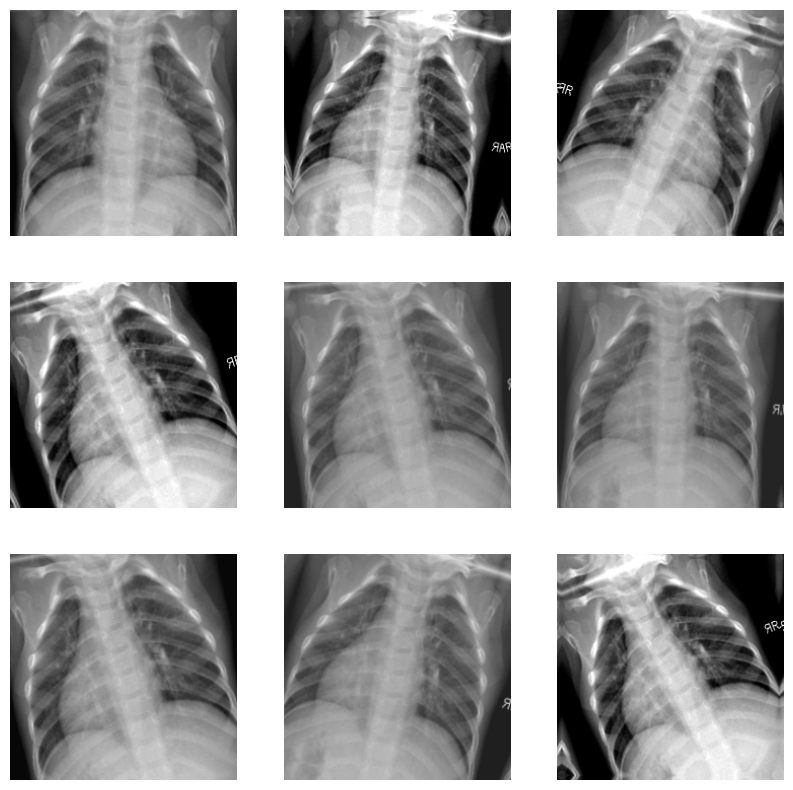

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10));

for images, _ in trainingData.take(1):
    for i in range(9):
        augmented_images = dataAugmentation(images);
        plt.subplot(3, 3, i + 1);
        plt.imshow(augmented_images[0].numpy().astype("uint8"));
        plt.axis("off");

Create model

In [14]:
from tensorflow.keras.models import Sequential

model = Sequential(
    [
        dataAugmentation,
        layers.Conv2D(
            32,
            3,
            padding="same",
            activation="relu",
        ),
        layers.Conv2D(
            64,
            3,
            padding="same",
            activation="relu",
        ),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Conv2D(
            64,
            3,
            padding="same",
            activation="relu",
        ),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Conv2D(
            128,
            3,
            padding="same",
            activation="relu",
        ),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Conv2D(
            128,
            3,
            padding="same",
            activation="relu",
        ),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(len(classNames), name="outputs"),
    ]
);

Visualize model

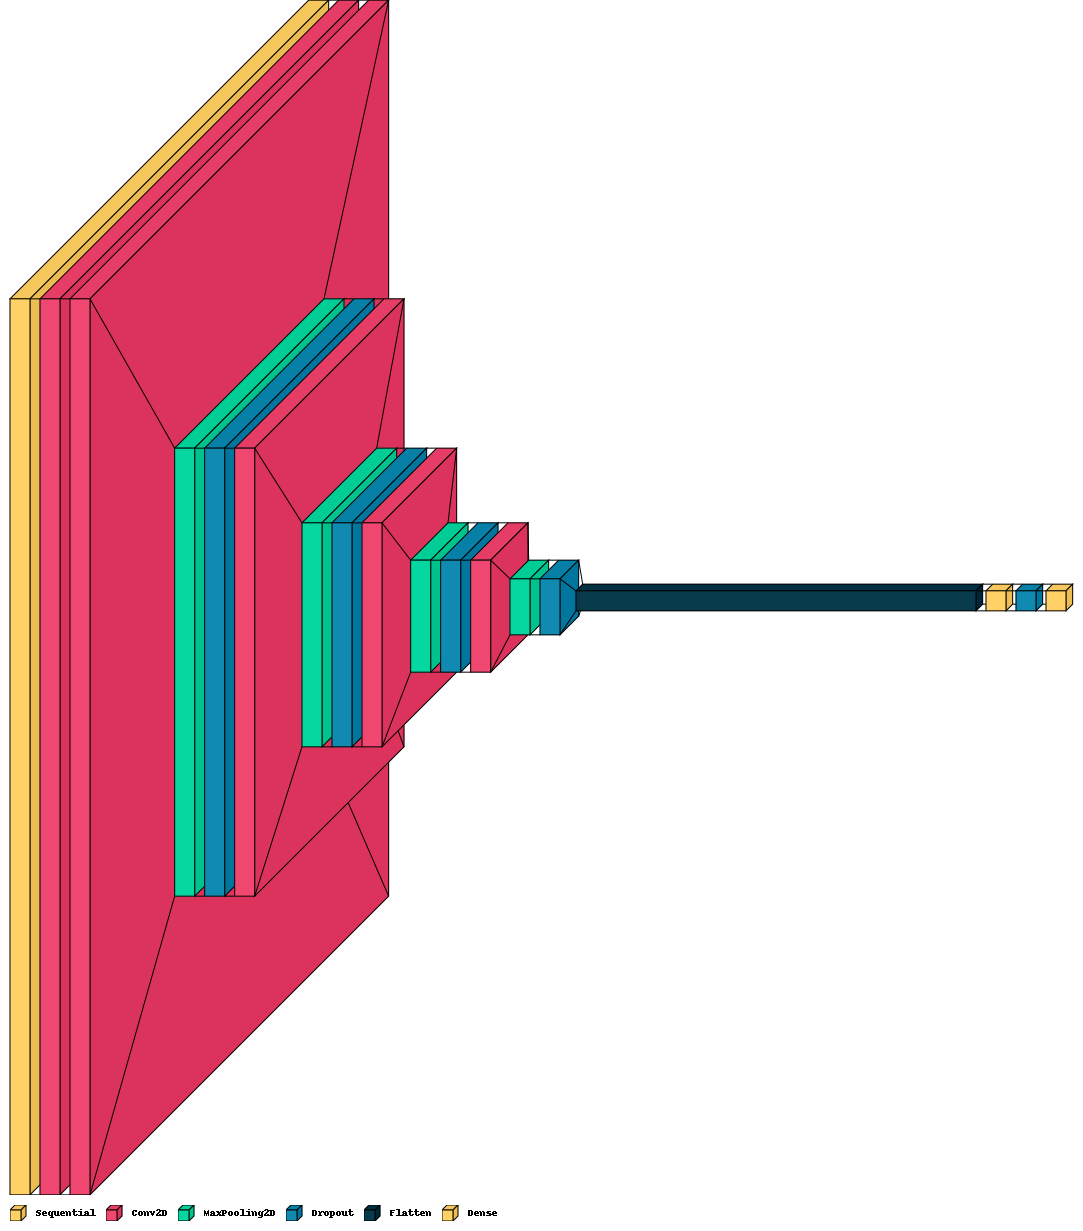

In [17]:
from PIL import ImageFont
import visualkeras

visualkeras.layered_view(model, to_file='output.png', legend=True).show();

Compile the model

In [30]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
);

model.summary();

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 64)      36928     
                                                      

Fit to training data

In [34]:
EPOCHS = 20;

history = model.fit(
    trainingData,
    validation_data=validationData,
    epochs=EPOCHS,
);

Epoch 1/20
153/153 [==============================] - 10s 65ms/step - loss: 0.1498 - accuracy: 0.9573 - val_loss: 0.1339 - val_accuracy: 0.9316
Epoch 2/20
153/153 [==============================] - 10s 66ms/step - loss: 0.1447 - accuracy: 0.9482 - val_loss: 0.2226 - val_accuracy: 0.9079
Epoch 3/20
153/153 [==============================] - 10s 67ms/step - loss: 0.1564 - accuracy: 0.9521 - val_loss: 0.2217 - val_accuracy: 0.9289
Epoch 4/20
153/153 [==============================] - 10s 67ms/step - loss: 0.2008 - accuracy: 0.9396 - val_loss: 0.0983 - val_accuracy: 0.9632
Epoch 5/20
153/153 [==============================] - 10s 64ms/step - loss: 0.1364 - accuracy: 0.9541 - val_loss: 0.0957 - val_accuracy: 0.9605
Epoch 6/20
153/153 [==============================] - 10s 65ms/step - loss: 0.1647 - accuracy: 0.9423 - val_loss: 0.1497 - val_accuracy: 0.9368
Epoch 7/20
153/153 [==============================] - 10s 65ms/step - loss: 0.1722 - accuracy: 0.9442 - val_loss: 0.1160 - val_accuracy:

Plot accuracy

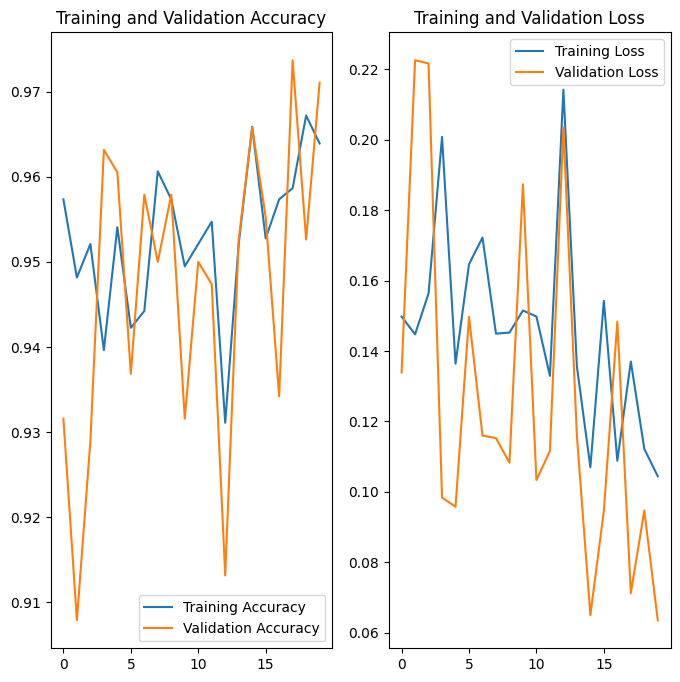

In [35]:
acc = history.history["accuracy"];
validationAcc = history.history["val_accuracy"];

loss = history.history["loss"];
validationLoss = history.history["val_loss"];

epochsRange = range(EPOCHS);

plt.figure(figsize=(8, 8));
plt.subplot(1, 2, 1);
plt.plot(epochsRange, acc, label="Training Accuracy");
plt.plot(
    epochsRange,
    validationAcc,
    label="Validation Accuracy",
);
plt.legend(loc="lower right");
plt.title("Training and Validation Accuracy");

plt.subplot(1, 2, 2);
plt.plot(epochsRange, loss, label="Training Loss");
plt.plot(
    epochsRange,
    validationLoss,
    label="Validation Loss",
);
plt.legend(loc="upper right");
plt.title("Training and Validation Loss");
plt.show();